<h1 style="text-align:center;">Covid-19 X-ray using ResNet-50</h1>


* <u>**Author**</u> **:**[Younes Dahami](https://www.linkedin.com/in/dahami/)

![](covid_resnet50.jpg)


COVID-19 pandemic is one of the biggest challenges for the healthcare system right now. It is a respiratory disease that affects our lungs and can cause lasting damage to the lungs that led to symptoms such as difficulty in breathing and in some cases pneumonia and respiratory failure. In this article, we will use X-ray data of lungs normal and COVID-positive patients and train a model to differentiate between them.

**What is the ResNet-50 model ?**

* **ResNet-50 :** stands for Residual Network and is a specific type of convolutional neural network (CNN) introduced in the 2015 paper “Deep Residual Learning for Image Recognition” by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian. CNNs are commonly used to power computer vision applications.

  * **Residual neural networks :** are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.
  
  * **ResNet-50 :** is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). 

In [8]:
#!pip install split-folders  pathlib opencv-python

In [51]:
import numpy as np
import pandas as pd
import opendatasets as od

import tensorflow as tf
import cv2, pathlib, splitfolders

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

import warnings 
warnings.filterwarnings("ignore") 

## 1) Importing the librairies and the  dataset

* `split-folders` is a tool to split a dataset into training, validation, and test sets.

* `cv2`: OpenCV library for computer vision tasks.

* `pathlib`: is a module providing classes representing filesystem paths.

* `splitfolders`: The library that was installed in the first line, used for splitting datasets into training, validation, and test sets.

* `from tensorflow.keras.preprocessing.image import ImageDataGenerator` : This line imports the ImageDataGenerator class from the `tensorflow.keras.preprocessing.image` module. `ImageDataGenerator` is used for real-time data augmentation on image data during model training.

* `from tensorflow.keras.layers import *`: This line imports all layers from the `tensorflow.keras.layers` module. These layers are used to construct neural network models in TensorFlow.

Let's set up some parameters for training the model :

In [26]:
epochs = 50
batch_size = 32 # B
im_height, im_width = 224,224  # 224px x 224px
input_shape = (im_height, im_width, 3)

* **Data augmentation :** is a technique to artificially increase the diversity of the training dataset by applying random transformations to the input images.

In [35]:
def create_data_binary(data_bs) :
    """ this code prepares and augments the dataset 
    for training a binary classification model using
    the provided dataset path."""
    
    # convertting dataset path "data_bs" into "pathlibh.Path" object
    data_bs = pathlib.Path(data_bs)
    
    # splitting the dataset into 70% training, 15 validation, and 15% testing
    splitfolders.ratio(data_bs, output="Imgs/", seed = 2510, ratio=(0.7,0.15,0.15), group_prefix=None)
    
    # Creating an istance of ImageDataGenerator which will be used to aygment the training data
    data_gen = ImageDataGenerator(rescale = 1.0/255,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 rotation_range = 10,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 samplewise_center = True,
                                 samplewise_std_normalization = True)
    
    # creating a training data generator
    train_ds = data_gen.flow_from_directory("Imgs/train/",
                                           target_size = (im_height, im_width),
                                           class_mode = "binary",
                                           batch_size = batch_size,
                                           subset = "training")
    
    # creating a test data generator
    test_ds = data_gen.flow_from_directory("Imgs/test/",
                                          target_size = (im_height, im_width),
                                          class_mode = "binary",
                                          batch_size = batch_size,
                                          shuffle = False)
    
    #  returning the training and test data generators
    return train_ds, test_ds

Let's download the dataset : 

In [17]:
url = "https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset/data"
od.download(url, data_dir = "./sarscov2-ctscan-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dahamey
Your Kaggle Key: ········


100%|███████████████████████████████████████████████████████████████████████████████| 230M/230M [01:47<00:00, 2.25MB/s]


In [36]:
train_data, test_data = create_data_binary("./sarscov2-ctscan-dataset/sarscov2-ctscan-dataset/")

Copying files: 2481 files [00:07, 331.32 files/s]


Found 1736 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


# 2) Building the model

## 2-1) Base model

We will work with the pretrained model ResNet50 as our base model.

In [44]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout,\
    BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam

In [38]:
# Laoding ResNet50
resnet = ResNet50(include_top = False,
                  weights = "imagenet",
                 input_shape = input_shape)

## 2-2) Adding new classifier layers

On top of the pre-trained model `resnet` we're going to add some layers :

In [43]:
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.BatchNormalization()(x) # normalization
x = tf.keras.layers.Dropout(0.7)(x)  # regularization
x = tf.keras.layers.Dense(units = 512, activation = tf.keras.layers.LeakyReLU())(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(units= 64, activation= tf.keras.layers.LeakyReLU())(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(units = 1, activation = "sigmoid")(x)

model_resnet = tf.keras.models.Model(inputs = resnet.input,
                                    outputs = x)

In [45]:
model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,680,193 (94.15 MB)

 Trainable params: 24,621,825 (93.92 MB)

 Non-trainable params: 58,368 (228.00 KB)

In [46]:
# pretrained are already training
for layer in model_resnet.layers[:120] :
    layer.trainable = False

## 2-3) Compilation

In [47]:
optimizer = Adam(learning_rate = 0.001)
model_resnet.compile(optimizer = optimizer,
                    loss = "binary_crossentropy",
                    metrics = ["accuracy"])

In [48]:
model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,680,193 (94.15 MB)

 Trainable params: 18,302,721 (69.82 MB)

 Non-trainable params: 6,377,472 (24.33 MB)

## 3-3) Training the model

* `batch_size` : is the number of samples per gradient update.

* The callbacks parameter takes a list of callbacks that will be called during training :
  * `tf.keras.callbacks.EarlyStopping`: This callback monitors the validation loss (`val_loss`) and stops training if no improvement is seen after a certain number of epochs (`patience`). It restores the best weights (`restore_best_weights=True`) based on the validation loss.
  
  * `tf.keras.callbacks.ReduceLROnPlateau`: This callback reduces the learning rate (`factor=0.1`) when the validation loss has stopped improving for a certain number of epochs (`patience`). It monitors the validation loss (`val_loss`) and updates the learning rate accordingly.

In [49]:
# Fitting the modelto the train data
history_resnet = model_resnet.fit(train_data,
                                 validation_data = test_data,
                                 epochs = epochs,
                                 batch_size = 16,
                                 callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5,
                                                                              monitor = "val_loss",
                                                                              mode = "min",
                                                                              restore_best_weights = True),
                                             tf.keras.callbacks.ReduceLROnPlateau(patience = 2,
                                                                                 monitor = "val_loss",
                                                                                 mode = "min",
                                                                                 factor = 0.1)
                                             ])


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 470s 8s/step - accuracy: 0.6101 - loss: 0.8308 - val_accuracy: 0.6337 - val_loss: 21.0701 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 435s 8s/step - accuracy: 0.7500 - loss: 0.5478 - val_accuracy: 0.7834 - val_loss: 2.5278 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 436s 8s/step - accuracy: 0.8237 - loss: 0.4019 - val_accuracy: 0.7112 - val_loss: 2.3010 - learning_rate: 0.0010
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 470s 8s/step - accuracy: 0.8410 - loss: 0.3726 - val_accuracy: 0.6444 - val_loss: 3.2309 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 546s 10s/step - accuracy: 0.8563 - loss: 0.3273 - val_accuracy: 0.8182 - val_loss: 1.5183 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 670s 12s/step - accuracy: 0.8627 - loss: 0.3241 - val_accuracy: 0.8048 - val_loss: 0.6143 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 493s 9s/step - accuracy: 0.8519 - loss: 0.3361 - val_

## 3-4) Evaluation

In [50]:
loss_resnet, acc_resnet = model_resnet.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9295 - loss: 0.1653


In [60]:
def create_charts(cnn, cnn_model) :
    # training & validation loss
    train_loss = cnn_model.history["loss"]
    val_loss = cnn_model.history["val_loss"]
    
    # training and validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    # y_pred & y_true
    y_true = test_data.classes
    Y_pred = cnn.predict(test_data, steps = len(test_data))
    y_pred = (Y_pred > .5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    # Plotting
    fig = plt.figure(figsize = (13,10))
    
    # Plot 1 : Training Vs Validation loss
    plt.subplot(2,2,1)
    plt.title("Training Vs. Validation Loss")
    plt.plot(train_loss, label = "training loss")
    plt.plot(val_loss, label = "validation loss")
    plt.xlabel("Number of Epochs", size = 14)
    plt.legend()
    
    # Plot 2 : training Vs. Validation AUC
    plt.subplot(2,2,2)
    plt.title("Training Vs. Validation AUC Score")
    plt.plot(train_auc, label = "training auc")
    plt.plot(val_auc, label = "validation auc")
    plt.xlabel("Number of Epochs", size = 14)
    plt.legend()
    
    # Plot 3 : confusion matrix
    plt.subplot(2,2,3)
     ## set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ["True Negatives", "False Positives", "False Negatives", "True Positives"]
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:0.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(names, percentages)]
    labels = np.asanyarray(labels).reshape(2,2)
    ticklabels = ["Normal", "Pneumonia"]
    
     ## Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt = '', cmap="Oranges", xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size = 14)
    plt.ylabel("Actual", size = 14)
    plt.savefig("cm.png", transparent = True)
    
    # Plot 4 :ROC curve
    plt.subplot(2,2,4)
    fpr, tpr, tresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title("ROC Curve")
    plt.plot([0, 1], [0, 1], "k--", label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label = "Resnet50 (AUC = {:.2f}%)".format(auc*100))
    plt.xlabel("False Positive Rate", size=14)
    plt.ylabel("True Positive Rate", size = 14)
    plt.legend(loc = "best")
    plt.savefig("roc.png", bbox_inches = "tight", pad_inches = 1)
    
    # End plots
    plt.tight_layout()
    
    # Summary statistics
    ## cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    TN, FP, FN, TP = cm.ravel()
    ## % correct predictions out of all 
    accuracy = (TP + TN) / np.sum(cm)
    ## % positive out of all predicted positives
    precision = TP / (TP + FP)
    ## % positive out of all supposed to be positives
    recall = TP / (TP + FN)
    ## % negative out of all supposed to be negatives
    specificity = TN / (TN + FP)
    f1 = 2*precision*recall / (precision+recall)
    stats_summary = "[Sumamry Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}".format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)


12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step
[Sumamry Statistics]
Accuracy = 91.98% | Precision = 94.29% | Recall = 89.19% | Specificity = 94.71% | F1 Score = 91.67%


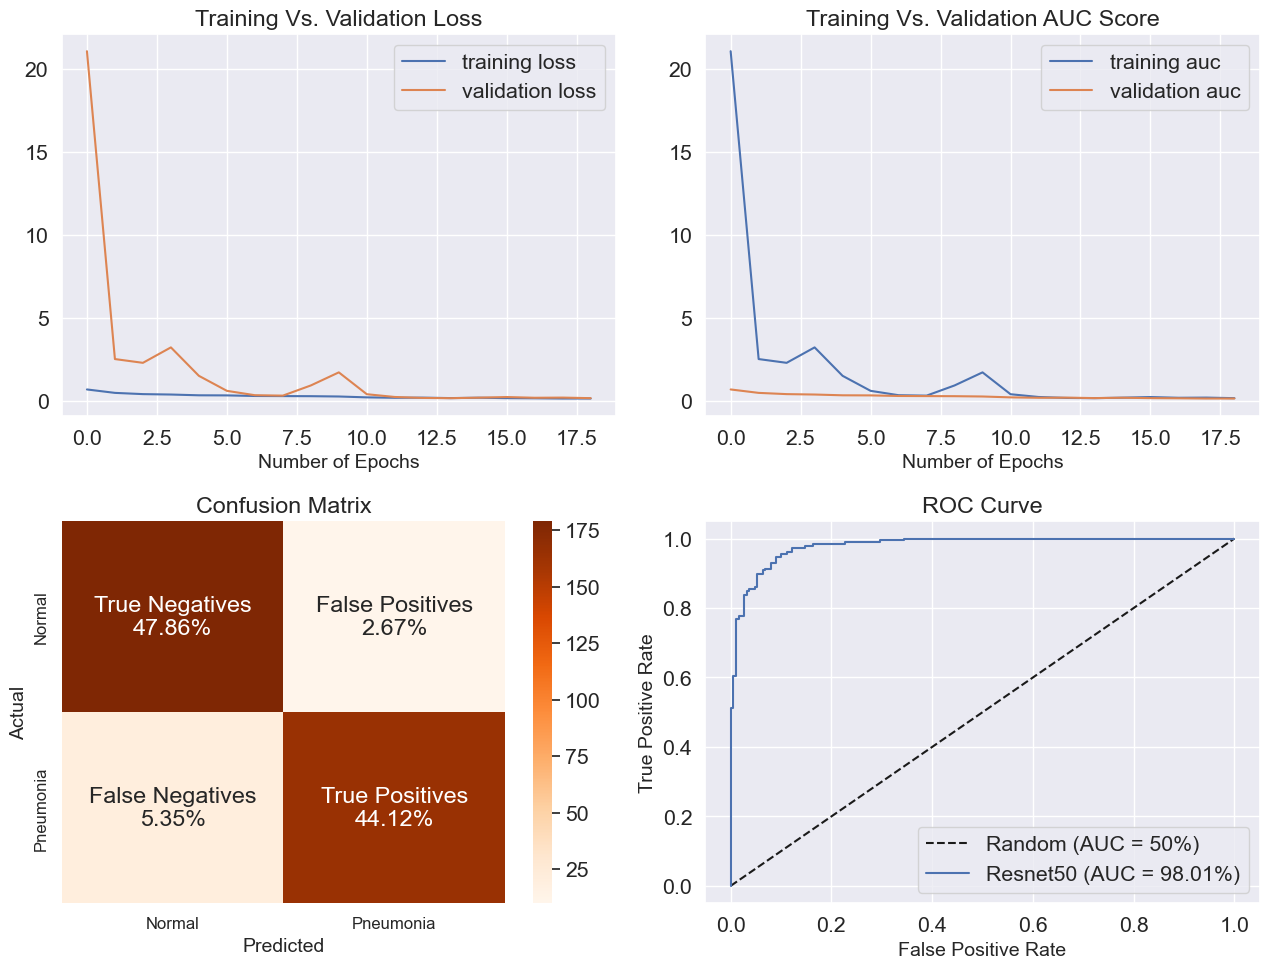

In [61]:
create_charts(model_resnet, history_resnet)

In [66]:
model_resnet.save("Covid-19 X-ray.keras")

# Change Log

| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2024-01-13       | 1.0     | Younes Dahami   |  initial version |
